# Visualization of Cepstrum procedure in voiced signal

This script is done to analyse the procedure to estimate the pitch based on cepstrum coefficients.
First we are going to choose a frame to analyse.

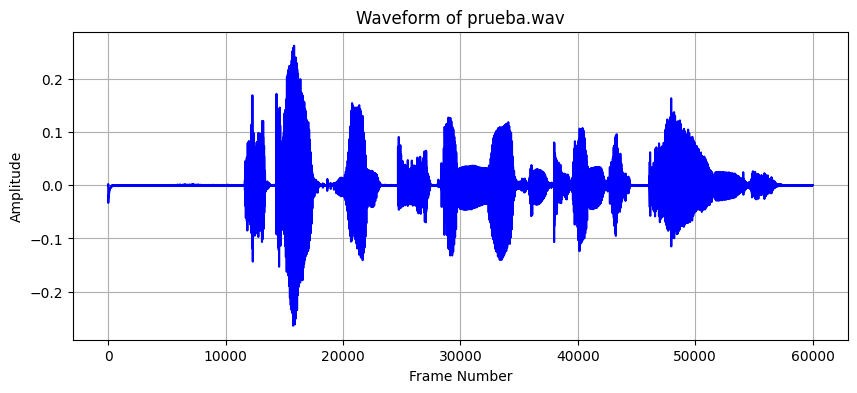

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

filename = "../../prueba.wav"
audio_data, sample_rate = sf.read(filename)

frame_numbers = np.arange(len(audio_data))

plt.figure(figsize=(10, 4))
plt.plot(frame_numbers, audio_data, color='b')
plt.title('Waveform of prueba.wav')
plt.xlabel('Frame Number')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

We are choosing the frame between 16000 and 16500.

600


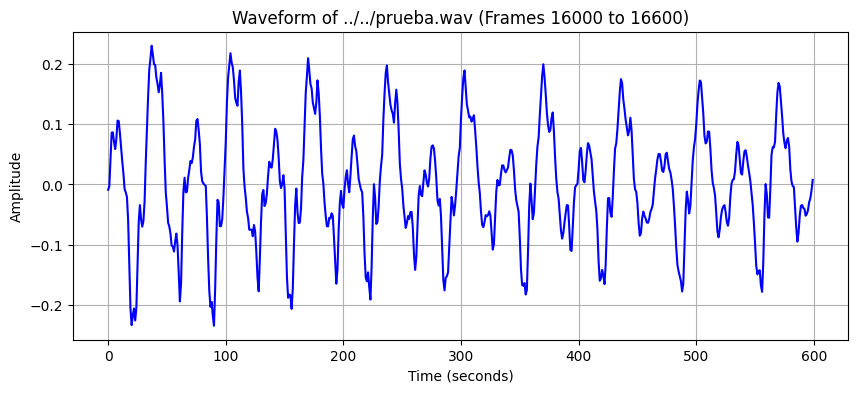

In [2]:
frame_length_ms = 30
frame_length_samples = int(frame_length_ms * sample_rate / 1000)
print(frame_length_samples)
start_frame = 16000
end_frame = start_frame + frame_length_samples

start_index = start_frame
end_index = min(end_frame, len(audio_data))

audio_data_frame = audio_data[start_index:end_index]

plt.figure(figsize=(10, 4))
plt.plot(audio_data_frame, color='b')
plt.title('Waveform of {} (Frames {} to {})'.format(filename, start_frame, end_frame))
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

We apply linear filters just to visualize the difference

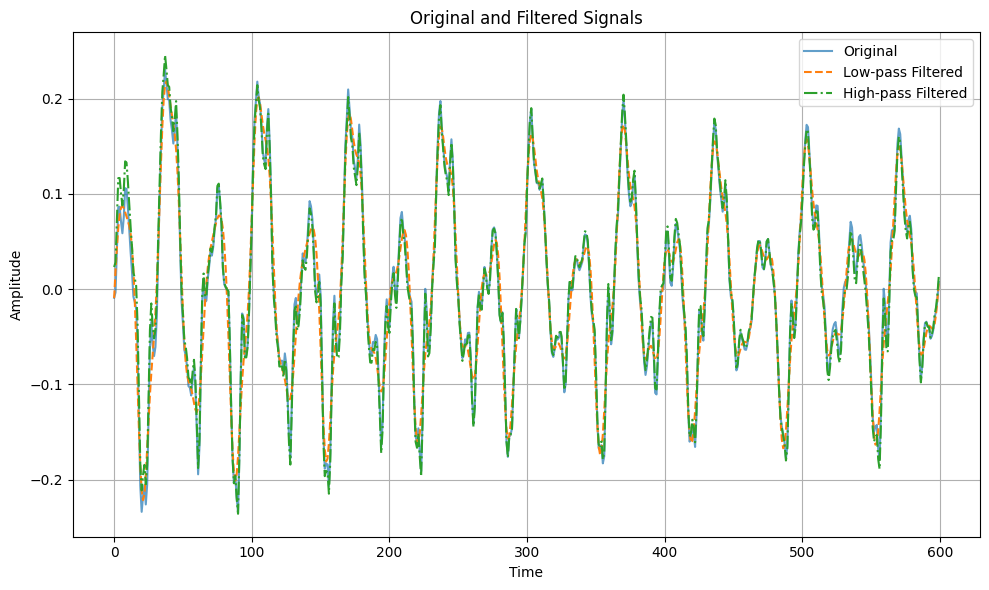

In [7]:
from scipy.signal import butter, sosfiltfilt

cutoff_low = 2000  # Low-pass cutoff frequency in Hz
cutoff_high = 50  # High-pass cutoff frequency in Hz

sos_low = butter(10, cutoff_low, 'lowpass', fs=sample_rate, output='sos')
sos_high = butter(10, cutoff_high, 'highpass', fs=sample_rate, output='sos')

filtered_low = sosfiltfilt(sos_low, audio_data_frame)
filtered_high = sosfiltfilt(sos_high, audio_data_frame)

plt.figure(figsize=(10, 6))
plt.plot(audio_data_frame, label='Original', alpha=0.7)

plt.plot(filtered_low, label='Low-pass Filtered', linestyle='--')
plt.plot(filtered_high, label='High-pass Filtered', linestyle='-.')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Original and Filtered Signals')
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

We apply centre clipping without offset.

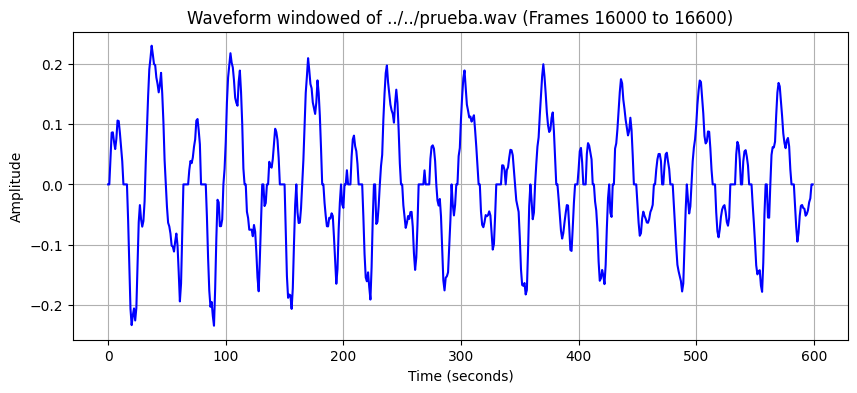

In [50]:
def center_clipping(audio_data, threshold):
    clipped_data = []
    for sample in audio_data:
        if sample > threshold:
            clipped_data.append(sample)
        elif sample < -threshold:
            clipped_data.append(sample)
        else:
            clipped_data.append(0)
    return clipped_data

threshold = max(audio_data_frame)/10
clipped_audio_data_frame = center_clipping(audio_data_frame, threshold)

plt.figure(figsize=(10, 4))
plt.plot(clipped_audio_data_frame, color='b')
plt.title('Waveform windowed of {} (Frames {} to {})'.format(filename, start_frame, end_frame))
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

We apply the hamming window.

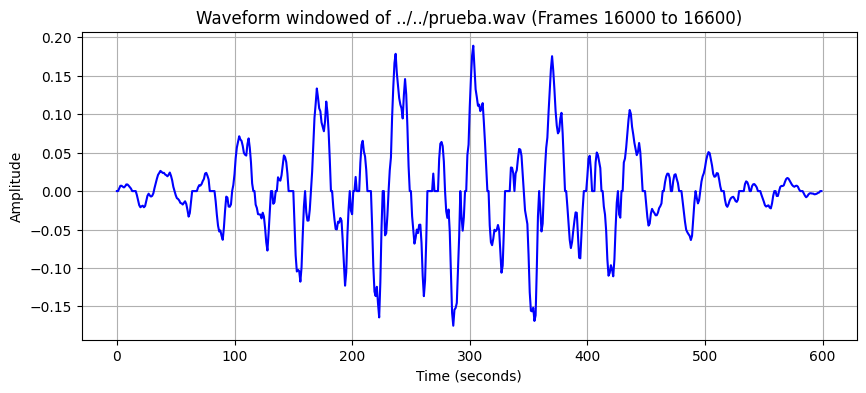

In [51]:

window_length = len(clipped_audio_data_frame)

hamming_window = np.hamming(window_length)

audio_data_frame_windowed = clipped_audio_data_frame * hamming_window

plt.figure(figsize=(10, 4))
plt.plot(audio_data_frame_windowed, color='b')
plt.title('Waveform windowed of {} (Frames {} to {})'.format(filename, start_frame, end_frame))
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

Compute the FFT of this signal. First we need to fill the signal with zeros. (zero padding)

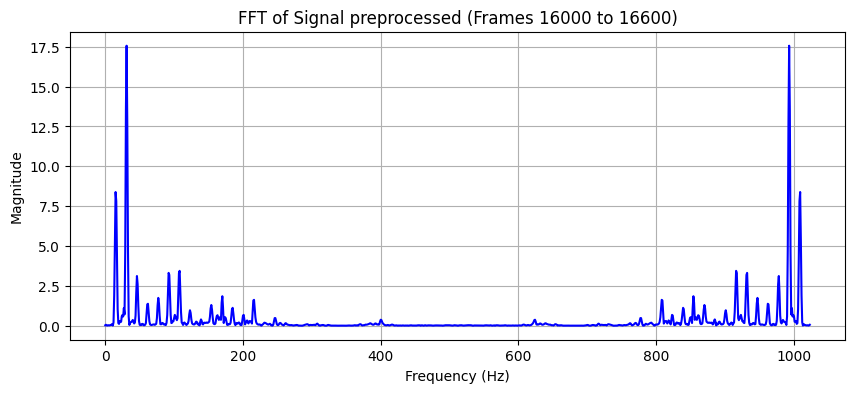

In [41]:
next_pow_of_2 = int(2 ** np.ceil(np.log2(len(audio_data_frame_windowed))))
audio_processed = np.pad(audio_data_frame_windowed, (0, next_pow_of_2 - len(audio_data_frame_windowed)), mode='constant')

fft = np.fft.fft(audio_processed)

plt.figure(figsize=(10, 4))
plt.plot(np.abs(fft), color='b')
plt.title('FFT of Signal preprocessed (Frames {} to {})'.format(start_frame, end_frame))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

We take the logarithm of the module of the signal.

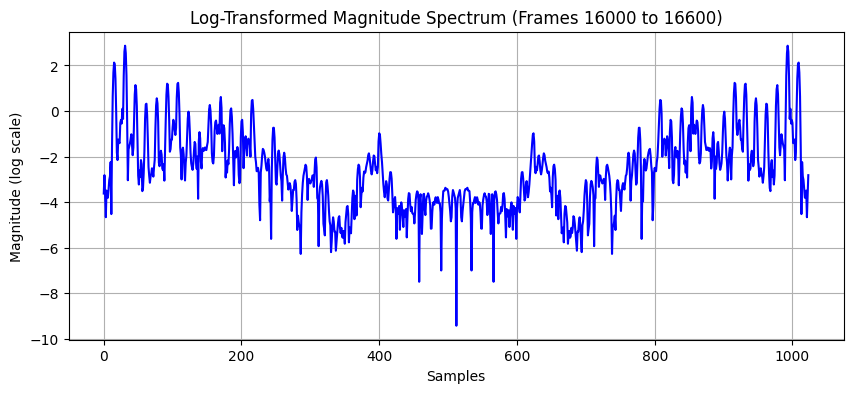

In [42]:
magnitude_spectrum = np.log(np.abs(fft))

plt.figure(figsize=(10, 4))
plt.plot(magnitude_spectrum, color='b')
plt.title('Log-Transformed Magnitude Spectrum (Frames {} to {})'.format(start_frame, end_frame))
plt.xlabel('Samples')
plt.ylabel('Magnitude (log scale)')
plt.grid(True)
plt.show()

Lastly, we compute the inverse fourier transform.

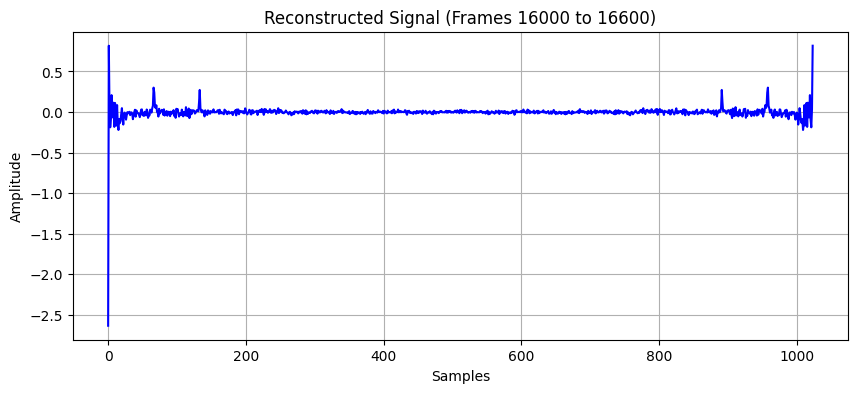

In [43]:
reconstructed_signal = np.fft.ifft(magnitude_spectrum)

plt.figure(figsize=(10, 4))
plt.plot(reconstructed_signal.real, color='b')
plt.title('Reconstructed Signal (Frames {} to {})'.format(start_frame, end_frame))
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

Zoom the signal to see its caracteristics.

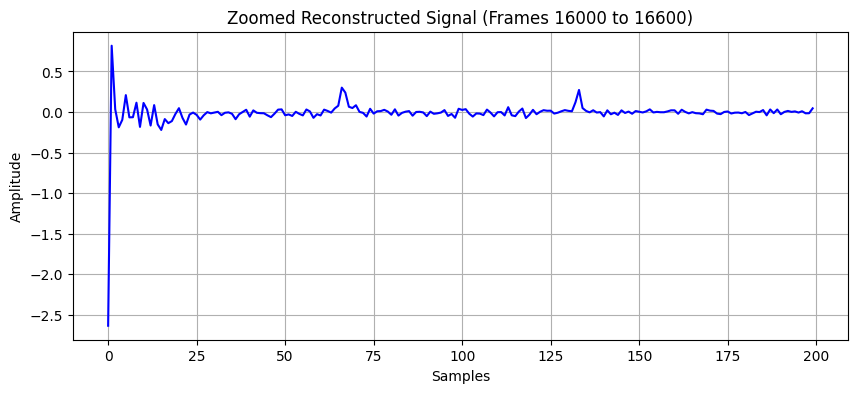

In [44]:
plt.figure(figsize=(10, 4))
plt.plot(reconstructed_signal.real[:200], color='b')
plt.title('Zoomed Reconstructed Signal (Frames {} to {})'.format(start_frame, end_frame))
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Save the signal to compare it with the unvoiced one
file_path = 'voiced.txt'

with open(file_path, 'w') as file:
    for value in reconstructed_signal.real:
        file.write(f"{value}\n")

Finally we find the first maximum in 66. So we are now able to find an estimation of the pitch.

In [45]:
index_max = 66

pitch = sample_rate / index_max

print(pitch)

303.030303030303


In [46]:
from collections import Counter

def entropy(signal):
    symbol_counts = Counter(signal)
    probabilities = np.array(list(symbol_counts.values())) / len(signal)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

print("Entropy:", entropy(audio_data_frame))
print("Entropy:", entropy(reconstructed_signal.real))

Entropy: 9.192152023829218
Entropy: 9.755859375


This part is just for us, because we wanted to see how does the cepstrum helps in compressing signals.

In [47]:
# import numpy as np
# from scipy.fftpack import dct
# from scipy.io import wavfile
# from sklearn.preprocessing import StandardScaler
# from scipy.fftpack import idct
# import os

# def mfcc(signal, num_ceps=13):
#     # Apply Discrete Cosine Transform (DCT) to log of the power spectrum
#     signal = np.log(np.abs(np.fft.rfft(signal)))  
#     mfcc_coeffs = dct(signal, type=2, axis=0, norm='ortho')[:num_ceps]
#     return mfcc_coeffs

# def inverse_mfcc(mfcc_coeffs):
#     signal = idct(mfcc_coeffs, type=2, axis=0, norm='ortho')
#     return np.exp(signal)

# def compress_signal(signal, num_bits=4):
#     # Quantization: reduce the precision of the signal
#     max_val = np.max(np.abs(signal))
#     quantized_signal = np.round(signal / max_val * (2**(num_bits-1) - 1))
#     return quantized_signal

# def decompress_signal(quantized_signal):
#     return quantized_signal / (2**(np.ceil(np.log2(np.abs(quantized_signal.max())))))


# # Compute MFCCs (Cepstral coefficients)
# cepstral_coeffs = mfcc(audio_data_frame)

# # Apply compression to the MFCCs
# compressed_coeffs = compress_signal(cepstral_coeffs)

# # Decompress the compressed MFCCs
# decompressed_coeffs = decompress_signal(compressed_coeffs)

# # Reconstruct the signal from the decompressed MFCCs
# reconstructed_signal = inverse_mfcc(decompressed_coeffs)

# print("Original Signal Entropy:", entropy(audio_data_frame))
# print("Compressed Signal:", entropy(compressed_coeffs))

In [48]:
# import matplotlib.pyplot as plt

# # Compute MFCCs (Cepstral coefficients)
# cepstral_coeffs = mfcc(audio_data_frame)

# # Apply compression to the MFCCs
# compressed_coeffs = compress_signal(cepstral_coeffs)

# # Decompress the compressed MFCCs
# decompressed_coeffs = decompress_signal(compressed_coeffs)

# Reconstruct the signal from the decompressed MFCCs
# reconstructed_signal = inverse_mfcc(decompressed_coeffs)

# # Calculate entropy of original signal and reconstructed signal
# original_entropy = entropy(audio_data_frame)
# reconstructed_entropy = entropy(reconstructed_signal)

# # Plotting
# fig, axes = plt.subplots(3, 2, figsize=(12, 10))

# # Original Signal
# axes[0, 0].plot(audio_data_frame)
# axes[0, 0].set_title('Original Signal')

# # Cepstral Coefficients
# axes[0, 1].plot(cepstral_coeffs)
# axes[0, 1].set_title('Cepstral Coefficients')

# # Compressed Coefficients
# axes[1, 0].plot(compressed_coeffs)
# axes[1, 0].set_title('Compressed Coefficients')

# # Decompressed Coefficients
# axes[1, 1].plot(decompressed_coeffs)
# axes[1, 1].set_title('Decompressed Coefficients')

# # Reconstructed Signal
# axes[2, 0].plot(reconstructed_signal)
# axes[2, 0].set_title('Reconstructed Signal')

# # Adjust layout
# plt.tight_layout()
# plt.show()